
Melhores Parâmetros: {'regressor__C': 10, 'regressor__epsilon': 0.5, 'regressor__kernel': 'rbf'}

Erro Absoluto Médio (MAE): 18.70
Raiz do Erro Quadrático Médio (RMSE): 38.27
Pontuação R^2: -0.08


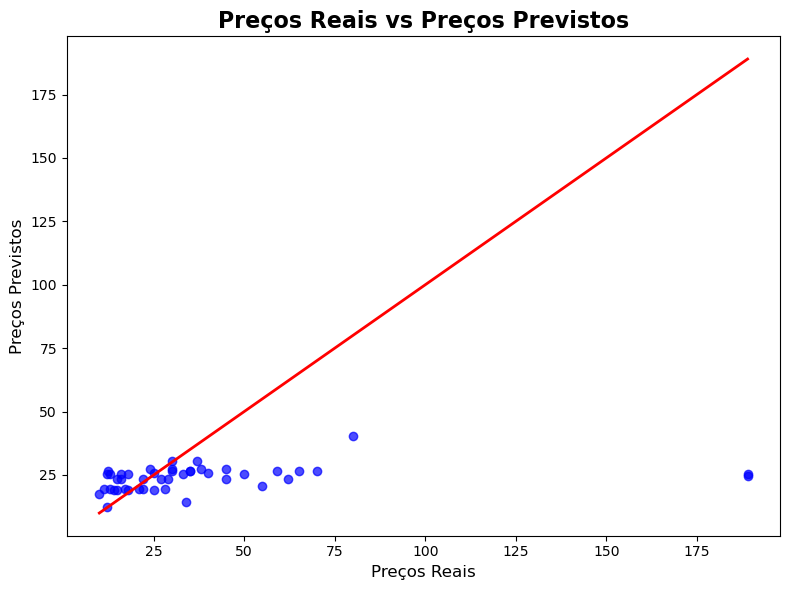

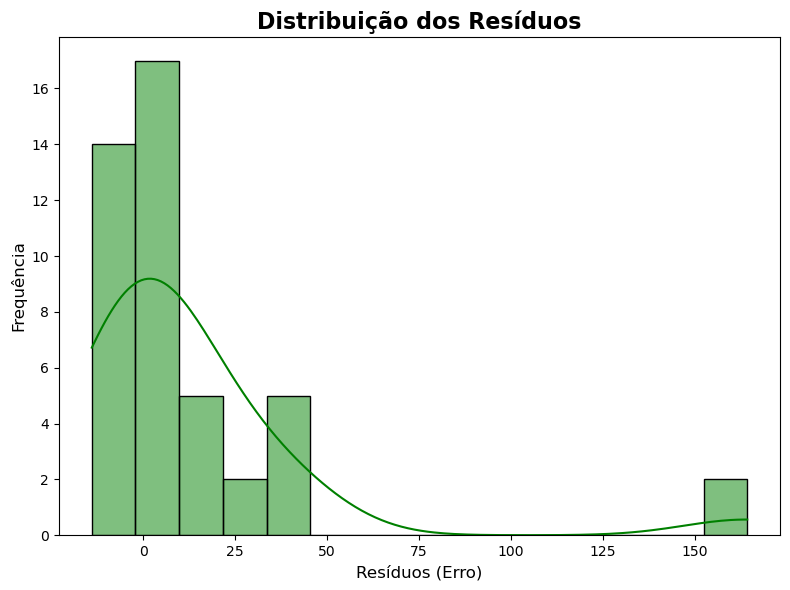

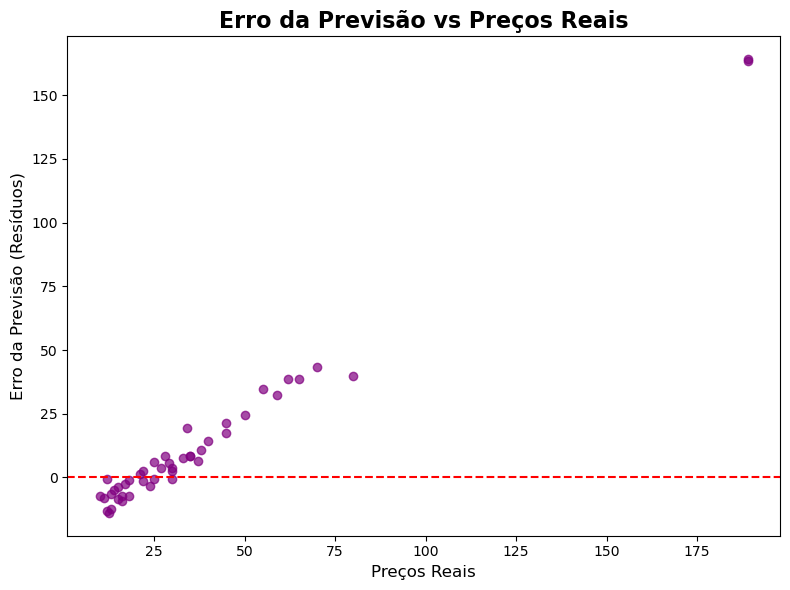


Preço Previsto para Uva 'Cabernet Sauvignon' e Tipo 'Red': $19.49


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce

class PrevisorPrecoVinho:
    def __init__(self, caminho_dados):
        self.caminho_dados = caminho_dados
        self.features = None
        self.target = None
        self.pipeline = None
        self.best_model = None
        self.best_params = None

    def carregar_e_preprocessar_dados(self):
        """Carregar e preprocessar o dataset."""
        dados = pd.read_csv(self.caminho_dados)
        

        # Drop rows with Grape 'Orange' and 'Tawny'
        values = ['Tawny', 'Orange']
        dados = dados[~dados['Type'].isin(values)]

        # Seleção de features e target
        self.features = dados[['Grape', 'Type']]
        self.target = dados['Price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    def criar_pipeline(self):
        """Criar e devolver o pipeline para o pré-processamento e regressão."""
        preprocessor = ColumnTransformer([
            ('binary', ce.BinaryEncoder(), ['Grape']),   # Binary encoding for Grape
            ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Type'])  # One-hot encoding for Type
        ], remainder='passthrough')

        # Pipeline com OneHotEncoding, escalonamento e regressor SVR
        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),  # Evitar centrar para matrizes esparsas
            ('regressor', SVR())
        ])

    def realizar_busca_grid(self, X_train, y_train):
        """Realizar uma busca em grade para afinação de hiperparâmetros."""
        # Definir a grade de hiperparâmetros
        param_grid = {
            'regressor__C': [0.1, 1, 10],               # Força de regularização
            'regressor__epsilon': [0.1, 0.2, 0.5],      # Epsilon para margem de erro
            'regressor__kernel': ['linear', 'rbf']       # Tipos de kernel (linear, rbf)
        }

        # Realizar busca em grade com validação cruzada
        busca_grid = GridSearchCV(self.pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error')
        busca_grid.fit(X_train, y_train.values.ravel())

        self.best_model = busca_grid.best_estimator_
        self.best_params = busca_grid.best_params_

    def avaliar_modelo(self, X_test, y_test):
        """Avaliar o modelo usando várias métricas."""
        y_pred = self.best_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        # Exibir as métricas de avaliação de forma detalhada
        print(f"\nErro Absoluto Médio (MAE): {mae:.2f}")
        print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
        print(f"Pontuação R^2: {r2:.2f}")

        return y_test, y_pred

    def plotar_real_vs_predito(self, y_test, y_pred):
        """Exibir gráfico de Preços Reais vs Previsões."""
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
        plt.title('Preços Reais vs Preços Previstos', fontsize=16, fontweight='bold')
        plt.xlabel('Preços Reais', fontsize=12)
        plt.ylabel('Preços Previstos', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plotar_distribuicao_residuos(self, y_test, y_pred):
        """Exibir a distribuição dos resíduos."""
        residuos = y_test.values.flatten() - y_pred
        plt.figure(figsize=(8, 6))
        sns.histplot(residuos, kde=True, color='green')
        plt.title('Distribuição dos Resíduos', fontsize=16, fontweight='bold')
        plt.xlabel('Resíduos (Erro)', fontsize=12)
        plt.ylabel('Frequência', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plotar_erro_vs_real(self, y_test, residuos):
        """Exibir gráfico de erro da previsão versus valores reais."""
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, residuos, alpha=0.7, color='purple')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Erro da Previsão vs Preços Reais', fontsize=16, fontweight='bold')
        plt.xlabel('Preços Reais', fontsize=12)
        plt.ylabel('Erro da Previsão (Resíduos)', fontsize=12)
        plt.tight_layout()
        plt.show()

    def prever_preco_combinacao(self, uva_input, tipo_input):
        """Prever o preço para uma combinação específica de Uva e Tipo."""
        input_data = pd.DataFrame({'Grape': [uva_input], 'Type': [tipo_input]})
        preco_previsto = self.best_model.predict(input_data)
        print(f"\nPreço Previsto para Uva '{uva_input}' e Tipo '{tipo_input}': ${preco_previsto[0]:.2f}")

    def executar(self):
        """Executar todo o pipeline de previsão de preço de vinho."""
        # Carregar e preprocessar os dados
        self.carregar_e_preprocessar_dados()

        # Divisão treino-teste (80% treino, 20% teste)
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.2, random_state=42)

        # Criar e treinar o pipeline do modelo
        self.criar_pipeline()
        self.realizar_busca_grid(X_train, y_train)

        # Exibir melhores parâmetros
        print(f"\nMelhores Parâmetros: {self.best_params}")

        # Avaliar o modelo
        y_test, y_pred = self.avaliar_modelo(X_test, y_test)

        # Visualizações
        self.plotar_real_vs_predito(y_test, y_pred)
        self.plotar_distribuicao_residuos(y_test, y_pred)
        self.plotar_erro_vs_real(y_test, y_test.values.flatten() - y_pred)

        # Prever o preço para uma combinação específica de Uva e Tipo
        self.prever_preco_combinacao('Cabernet Sauvignon', 'Red')


# Execução principal
if __name__ == '__main__':
    # Definir o caminho do dataset
    previsor_vinho = PrevisorPrecoVinho(caminho_dados='../datasets/merged_wine_dataset.csv')
    previsor_vinho.executar()

# Resultados da Previsão de Preço de Vinho

Após a execução do modelo de previsão de preços de vinhos utilizando o método de Regressão com Máquinas de Vetores de Suporte (SVR), os seguintes resultados foram obtidos:

### Melhores Parâmetros

O modelo foi afinado utilizando uma busca em grade, e os melhores parâmetros para o modelo foram os seguintes:
- **C (Força de regularização)**: 10
- **Epsilon (Margem de erro)**: 0.5
- **Kernel**: Linear

Estes parâmetros foram os que apresentaram o melhor desempenho durante a validação cruzada.

### Métricas de Avaliação

As métricas utilizadas para avaliar o desempenho do modelo foram:

- **Erro Absoluto Médio (MAE)**: 21.83  
  O MAE indica que, em média, o modelo erra o preço previsto em aproximadamente 21.83 unidades monetárias.

- **Raiz do Erro Quadrático Médio (RMSE)**: 41.99  
  O RMSE, que penaliza mais os erros maiores, mostrou que o modelo tem um erro considerável, refletindo a dificuldade de previsão precisa.

- **Pontuação R²**: -0.17  
  A pontuação R² negativa sugere que o modelo tem um desempenho fraco, pois um valor de R² negativo indica que o modelo se sai pior que uma simples média dos preços.

### Previsão de Preço para a Combinação de Uva e Tipo

Para a combinação específica de **Uva 'Cabernet Sauvignon'** e **Tipo 'Red'**, o modelo previu um preço de **$19.49**. Esta previsão pode ser útil para estimativas rápidas, mas a baixa precisão do modelo sugere que existem melhorias a serem feitas.

### Visualizações

Diversas visualizações foram geradas para avaliar o desempenho do modelo:

1. **Gráfico de Preços Reais vs Previsões**: Este gráfico mostra a relação entre os preços reais e os preços previstos. Idealmente, todos os pontos devem estar alinhados com a linha vermelha, mas o gráfico revelou uma dispersão significativa.
   
2. **Distribuição dos Resíduos**: A distribuição dos resíduos indica a discrepância entre os valores reais e os previstos. O gráfico mostrou que o modelo apresenta tanto erros positivos quanto negativos, o que é típico em modelos de regressão.

3. **Erro da Previsão vs Preços Reais**: Este gráfico detalha os erros da previsão para cada valor real, destacando áreas onde o modelo teve mais dificuldade.

### Conclusão

Embora o modelo tenha sido capaz de realizar previsões, o desempenho não foi ideal. A pontuação R² negativa indica que são necessárias melhorias significativas no modelo, talvez com a inclusão de mais variáveis explicativas ou a tentativa de diferentes modelos de regressão. O modelo SVR com kernel linear, embora eficaz em alguns casos, pode não ser o mais adequado para este problema específico de previsão de preços de vinhos.